In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import os
import cv2

os.environ["CUDA_VISIBLE_DEVICES"] = '-1'

from ssd_model import SSD512
from ssd_utils import PriorUtil

In [2]:
from data_voc import GTUtility
gt_util = GTUtility('data/VOC2007/')
num_classes = gt_util.num_classes

In [ ]:
model = SSD512(num_classes=num_classes)
model.load_weights('models/ssd512_voc_weights_fixed.hdf5', by_name=True)

priors_util = PriorUtil(model)

8/8 [==============================] - 2s 223ms/step


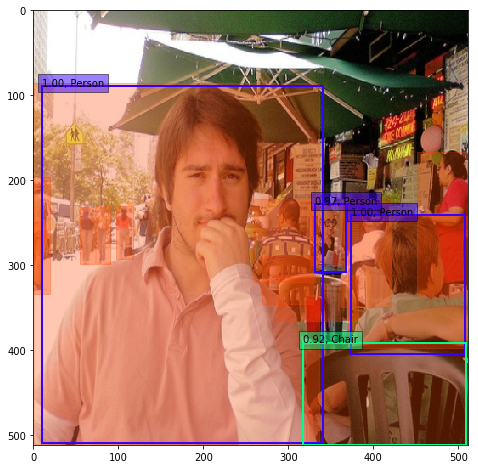

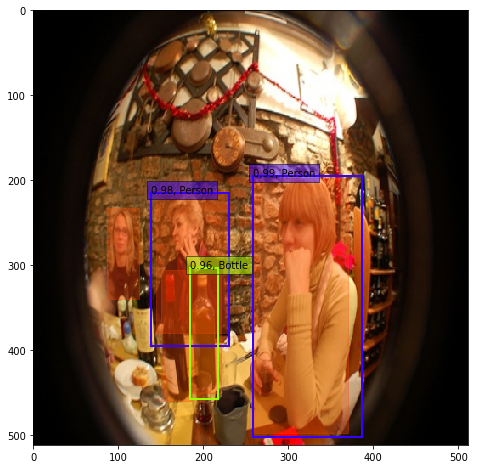

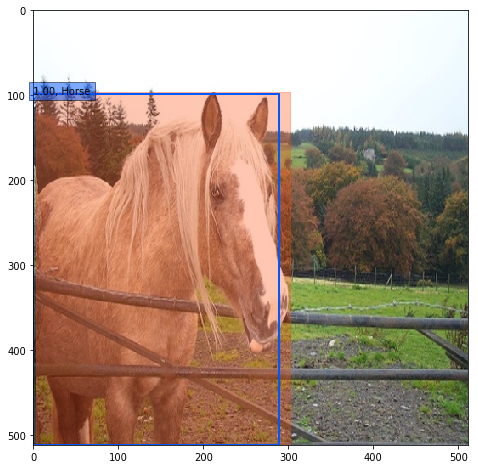

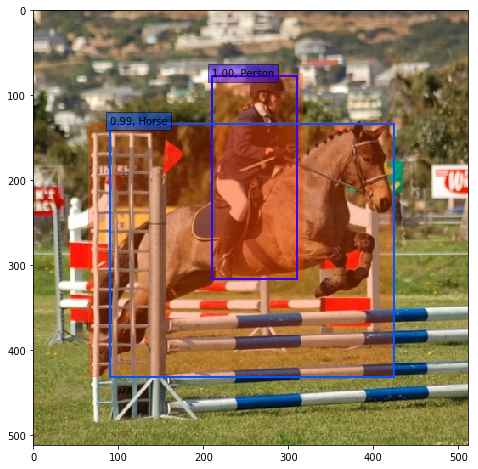

In [4]:
_, inputs, images, data = gt_util.sample_random_batch(batch_size=8, input_size=model.image_size)

preds = model.predict(inputs, batch_size=1, verbose=1)

results = [priors_util.decode(p, confidence_threshold=0.8) for p in preds]

for i in range(4):
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    priors_util.plot_results(results[i], classes=gt_util.classes, 
                             confidence_threshold=0.1, show_labels=True, gt_data=data[i])
    plt.show()

In [5]:
for m in priors_util.prior_maps:
    print('%-28s  locations: %-6i  aspect_ratios: %s' % (m.source_layer_name, m.num_locations, m.aspect_ratios))

conv4_3                       locations: 4096    aspect_ratios: [1, 2, 0.5]
fc7                           locations: 1024    aspect_ratios: [1, 2, 0.5, 3, 0.3333333333333333]
conv6_2                       locations: 256     aspect_ratios: [1, 2, 0.5, 3, 0.3333333333333333]
conv7_2                       locations: 64      aspect_ratios: [1, 2, 0.5, 3, 0.3333333333333333]
conv8_2                       locations: 16      aspect_ratios: [1, 2, 0.5, 3, 0.3333333333333333]
conv9_2                       locations: 4       aspect_ratios: [1, 2, 0.5]
conv10_2                      locations: 1       aspect_ratios: [1, 2, 0.5]


### Multi scale

In [6]:
# model

#input_shapes = [(512, 512, 3), (1024, 1024, 3)]
#input_shapes = [(512, 512, 3), (768, 768, 3), (1024, 1024, 3)]
input_shapes = [(512, 512, 3), (512, 1024, 3), (1024, 512, 3), (1024, 1024, 3)]

graphs = []
sessions = []
models = []
prior_utils = []

for i in range(len(input_shapes)):
    graph = tf.Graph()
    graphs.append(graph)
    with graph.as_default():
        session = tf.Session()
        sessions.append(session)
        with session.as_default():
            model = SSD512(input_shape=input_shapes[i], num_classes=gt_util.num_classes)
            models.append(model)
            model.load_weights('models/ssd512_voc_weights_fixed.hdf5')
            prior_util = PriorUtil(model)
            prior_utils.append(prior_util)

In [7]:
# prediction

inputs = []

for i, s in enumerate(input_shapes):
    _, inpusts_, images, data = gt_util.sample_random_batch(batch_size=8, input_size=s[:2], seed=1337)
    inputs.append(inpusts_)

preds_multi = []

for i in range(len(input_shapes)):
    with graphs[i].as_default():
        with sessions[i].as_default():
            model = models[i]
            preds = model.predict(inputs[i], batch_size=1, verbose=1)
            preds_multi.append(preds)

8/8 [==============================] - 6s 715ms/step


In [8]:
# decoding

from ssd_utils import non_maximum_suppression

def decode(prior_utils, model_outputs, confidence_threshold=0.7, keep_top_k=200, nms_top_k=400, nms_thresh=0.45):
    
    batch_size = len(model_outputs[0])
    num_models = len(model_outputs)
    results_ = []
    
    for i in range(batch_size):
        boxes_, confidence_, prior_mask_ = [], [], []

        for j in range(num_models):
            prior_util = prior_utils[j]
            model_output = model_outputs[j][i]

            # calculation is done with normalized sizes

            prior_mask = model_output[:,4:] > confidence_threshold

            # compute boxes only if the confidence is high enough and the class is not background
            mask = np.any(prior_mask[:,1:], axis=1)
            prior_mask = prior_mask[mask]
            mask = np.ix_(mask)[0]
            model_output = model_output[mask]
            image_wh = prior_util.image_size[::-1]

            priors_xy = prior_util.priors_xy[mask] / image_wh
            priors_wh = prior_util.priors_wh[mask] / image_wh
            priors_variances = prior_util.priors[mask,-4:]

            offsets = model_output[:,:4]
            confidence = model_output[:,4:]

            num_priors = offsets.shape[0]
            num_classes = confidence.shape[1]

            # compute bounding boxes from local offsets
            boxes = np.empty((num_priors, 4))
            offsets = offsets * priors_variances
            boxes_xy = priors_xy + offsets[:,0:2] * priors_wh
            boxes_wh = priors_wh * np.exp(offsets[:,2:4])
            boxes[:,0:2] = boxes_xy - boxes_wh / 2. # xmin, ymin
            boxes[:,2:4] = boxes_xy + boxes_wh / 2. # xmax, ymax
            boxes = np.clip(boxes, 0.0, 1.0)

            boxes_.append(boxes)
            confidence_.append(confidence)
            prior_mask_.append(prior_mask)

        boxes = np.vstack(boxes_)
        confidence = np.vstack(confidence_)
        prior_mask = np.vstack(prior_mask_)

        # do non maximum suppression
        results = []
        for c in range(1, num_classes):
            mask = prior_mask[:,c]
            boxes_to_process = boxes[mask]
            if len(boxes_to_process) > 0:
                confs_to_process = confidence[mask, c]

                idx = non_maximum_suppression(
                        boxes_to_process, confs_to_process, 
                        nms_thresh, nms_top_k)

                good_boxes = boxes_to_process[idx]
                good_confs = confs_to_process[idx][:, None]
                labels = np.ones((len(idx),1)) * c
                c_pred = np.concatenate((good_boxes, good_confs, labels), axis=1)
                results.extend(c_pred)
        if len(results) > 0:
            results = np.array(results)
            order = np.argsort(-results[:, 4])
            results = results[order]
            results = results[:keep_top_k]
        else:
            results = np.empty((0,6))

        results_.append(results)
    
    return results_

results = decode(prior_utils, preds_multi)

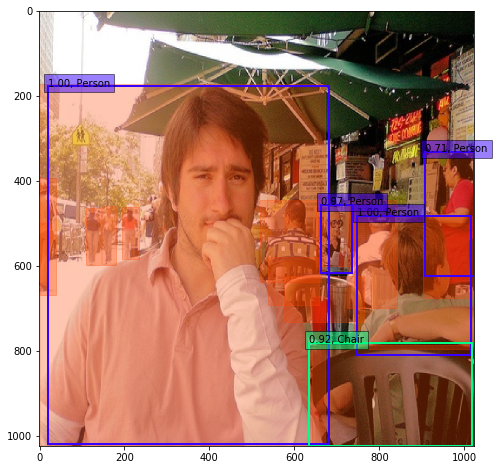

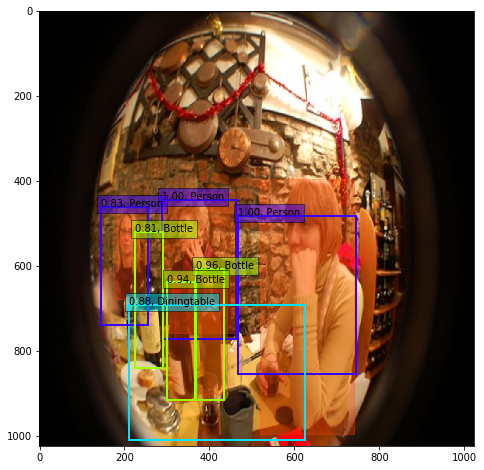

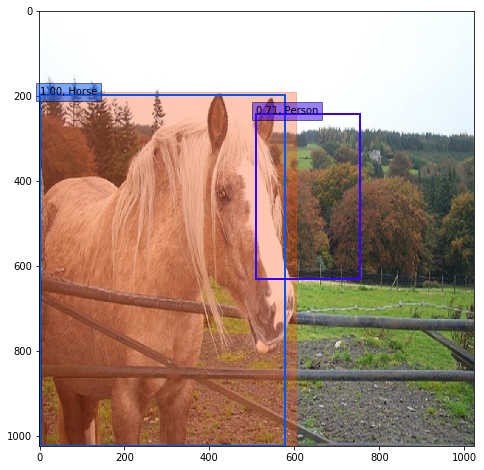

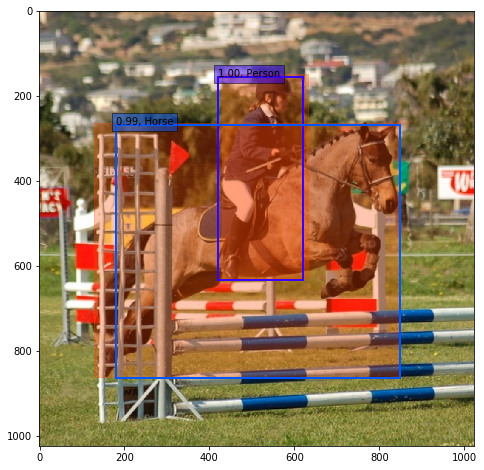

In [9]:
for i in range(4):
    plt.figure(figsize=[8]*2)
    plt.imshow(images[i])
    prior_util.plot_results(results[i], classes=gt_util.classes, show_labels=True, gt_data=data[i])
    plt.show()